In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.ornstein_uhlenbeck import OrnsteinUhlenbeck
from rivapy.models import WindPowerForecastModel, MultiRegionWindForecastModel, ResidualDemandForwardModel
from rivapy.pricing.green_ppa_pricing import price
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
import numpy as np
from scipy.special import comb

%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\doeltz\development\RiVaPy\notebooks\models\../..\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


# Models

In [2]:
def smoothstep(x, x_min=0, x_max=1, N=1):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)
    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n
    result *= x ** (N + 1)
    return result

def _logit(x):
    return np.log(x/(1-x))

def _inv_logit(x):
    return 1.0/(1+np.exp(-x))


class SmoothstepSupplyCurve: 
    def __init__(self, s,N):
        self.s = s
        self.N = N
        
    def compute(self, residual, highest_price):
        #wind_production = wind_production#np.maximum(np.minimum(wind_production, 0.99), 0.01)
        #residual = (1.0-wind_production)
        residual = np.power(residual, self.s)
        return smoothstep(residual, N=self.N)*highest_price


- $p(t,T)$: Forward-Price zum Zeitpunkt $t$ mit Expiry $T$
- $f_i(t,T)$: Forecast der i-ten Technology für $T$ zum Zeitpunkt $t$
    - Annahme: Forecast stueckweise Konstant in der Zeit (Sprung an Forecast Terminen)


Wuenschenswert:
- $f_i(t,T)=E\left[f_i(T,T)\mid f_i(t,T)\right]$
- $p(t,T)=E\left[p(T,T)\mid p(t,T)\right]$

Einfache Moeglichkeit (ohne die wuenschenswerten Punkte einzuhalten): 
- $c(t,T)$: Hoechster Preis, der aufgrund der Angebotskurve zustande kommen kann
- $r(x)$: Residual demand curve mit Werten zwischen 0 und 1
$$
p(t,T) = c(t,T)\cdot r(1.0 - \sum_i f_i(t,T))
$$
Unabghängigkeit von $c$ und $f_i$:
$$
E\left[p(T,T)\right] = E\left[c(T,T)\right]E\left[r(1.0 - \sum_i f_i(T,T))\right]
$$
und wenn 
$$E\left[c(T,T))\right]=c(t,T)$$ 
und 
$$E\left[r(1.0 - \sum_i f_i(T,T)\right]=r(1.0 - \sum_i f_i(t,T))$$
haben wir $p(t,T)=E\left[p(T,T)\mid p(t,T)\right]$. Wenn $r$ linear, d.h. $r(x)=x$ dann einfach!


$$
dF = \lambda(F-a-r(f))dt + \sigma dW
$$

In [3]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1] + 10*24*i/(365*24.0) for i in range(4)]
#forward_expiries = [timegrid[-1] + i for i in range(4)]
n_sims = 10_000
wind_forecast_model = WindPowerForecastModel(speed_of_mean_reversion=1.0, volatility=0.30, 
                             expiries=forward_expiries,
                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                            )

rnd = np.random.normal(size=wind_forecast_model.rnd_shape(n_sims, timegrid.shape[0]))
wind = wind_forecast_model.simulate(timegrid, rnd)

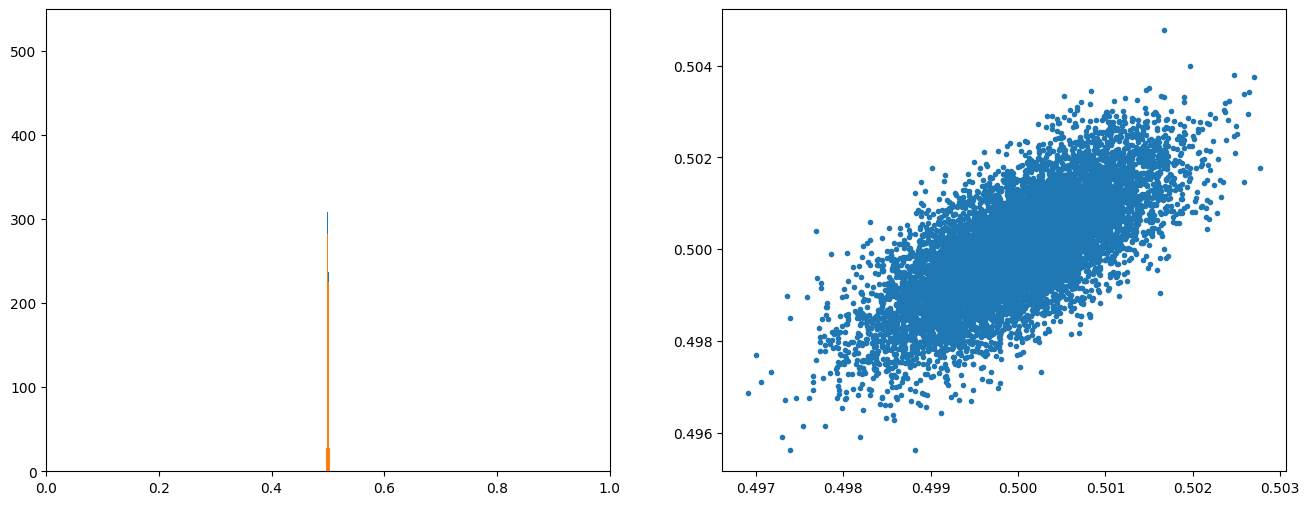

In [4]:
expiry1 = 1
expiry2 = 2#5*24
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(_inv_logit(wind._paths[expiry1,:]), density=True, bins=100)
plt.hist(_inv_logit(wind._paths[expiry2,:]), density=True, bins=100)
plt.xlim(0.0,1.0)
plt.subplot(1,2,2)
plt.plot(_inv_logit(wind._paths[expiry1,:]), _inv_logit(wind._paths[expiry2,:]), '.');

In [5]:
wind_forecast_model_2 = WindPowerForecastModel(speed_of_mean_reversion=2.0, volatility=0.6, 
                             expiries=forward_expiries,
                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                            )
region_wind_model = MultiRegionWindForecastModel([(0.5, wind_forecast_model, [0.6, 0.4]),
                              (0.5, wind_forecast_model_2, [0.4, 0.6])])

In [6]:
results = region_wind_model.simulate(timegrid, rnd)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
expiry = -1
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(_inv_logit(results[0]._paths[expiry,:]), _inv_logit(results[1]._paths[expiry,:]), '.');

plt.subplot(1,2,2)
plt.hist(_inv_logit(results[0]._paths[expiry,:]), density=True, label='region 0', bins=100)
plt.hist(_inv_logit(results[1]._paths[expiry,:]),  density=True, label='region 1', bins=100, alpha=0.8);


In [ ]:
for fwd in [0,-1]:#range(wind.n_forwards()):
    fwd_values = wind.get_fwd(0, fwd)
    plt.hist(fwd_values, bins=100, label='expiry ' + str(wind.expiry(fwd))[:6], alpha=0.3, density=True)
plt.legend();

In [ ]:
timestep = 20
fwd1 = 0
fwd2 = 1
fwd_values1 = wind.get_fwd(timestep, fwd1)
fwd_values2 = wind.get_fwd(timestep, fwd2)
plt.plot(fwd_values1, fwd_values2, '.', alpha=0.1)
plt.legend();

In [ ]:
highest_price = OrnsteinUhlenbeck(1.0, 1.0, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rdm = ResidualDemandForwardModel(wind_forecast_model, highest_price, supply_curve)

In [ ]:
n_sims = 1000
rnd = np.random.normal(size=(2,timegrid.shape[0], n_sims))
fwd_prices, fwd_residuals = rdm.simulate(timegrid, rnd, forecast_points, highest_price=1000)

In [ ]:
plt.figure(figsize = (16,4))
plt.subplot(1,3,1)
for T in [-2,0]:
    label = 'T='+str(forward_expiries[T])[:6]
    color = None
    for i in range(100):
        lines = plt.plot(timegrid, fwd_prices[:,i,T], '-', alpha=0.1, label=label, color = color)
        color = lines[0].get_color()
        label=None
plt.xlabel('t')
plt.ylabel('$p(t,T)$')
plt.legend()
    #plt.plot(timegrid, result[:,i,2], '-r', alpha=0.1)
plt.subplot(1,3,2)
x = np.linspace(0.0,1.0,50)
plt.plot(x,rdm.supply_curve.compute(x, 1000))
plt.xlabel('residual demand')
plt.ylabel('price')
plt.subplot(1,3,3)
for T in [-2,0]:
    label = 'T='+str(forward_expiries[T])
    color = None
    for i in range(100):
        plt.plot(timegrid, 1.0-fwd_residuals[:,i,T], '-', color = color, alpha=0.1)
        color = lines[0].get_color()
        label=None
plt.xlabel('t')
plt.ylabel('$f_i(t,T)$')
plt.legend();

In [ ]:
plt.figure(figsize = (16,4))

for T in [0,1,2]:
    plt.subplot(1,3,T+1)
    label = 'T='+str(forward_expiries[T])[:6]
    plt.plot( 1.0-fwd_residuals[-1,:,T], fwd_prices[-1,:,T], '.', alpha=0.1, label=label)
    label=None
plt.ylabel('$p(T,T)$')
plt.xlabel('$f_i(T,T)$')
plt.legend();

In [ ]:
fwd_prices[-1,:,T].shape

In [ ]:
for i in range(100):
    plt.plot(timegrid, result[:,i,-2], '-b', alpha=0.1)
    #plt.plot(timegrid, result[:,i,2], '-r', alpha=0.1)

In [ ]:
wind = WindPowerForecastModel(speed_of_mean_reversion=0.20, volatility=0.4, 
                             expiries=[1.0+i/(365.0*24.0) for i in range(24)],
                            forecasts = [0.8-i*0.4/23.0 for i in range(24)])

timegrid = np.linspace(0.0, 1.0, 100)
rnd = np.random.normal(size=(timegrid.shape[0], 100_000))
paths = wind.simulate(timegrid, rnd)

expiry = 0
timepoint = 99
t = timegrid[timepoint]
fwd = wind.get_forward(paths[timepoint], t, expiry)
print(np.mean(fwd))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(fwd, bins = 100);
plt.subplot(1,2,2)
plt.plot(paths[timepoint], fwd,'.');

In [ ]:

timepoint = -1
forecast = 0.001
ou = OrnsteinUhlenbeck(speed_of_mean_reversion=0.20, volatility=0.4, mean_reversion_level=0.0)
timegrid = np.linspace(0.0, 1.0, 100)
#scaling = 
correction = _logit(forecast)-ou.compute_expected_value(0.0, timegrid[timepoint])

print(_inv_logit(ou.compute_expected_value(0.0, timegrid[timepoint])+correction))
rnd = np.random.normal(size=(timegrid.shape[0], 100_000))
paths = ou.simulate(timegrid, 0.0, rnd) + correction
paths_inv_logit = _inv_logit(paths)

#plt.hist(paths[-1,:], bins=100)
plt.hist(paths_inv_logit[timepoint,:], bins=100);
print('mean ou path ', np.mean(paths[timepoint,:]), 'inverse_logit of mean ',_inv_logit(np.mean(paths[timepoint,:])), 
      ' mean of inverse logit',np.mean(paths_inv_logit[timepoint,:]))

_logit(forecast)

## MultiRegionWindForecastModel

In [15]:
from rivapy.models.residual_demand_model import MultiRegionWindForecastModel
forward_expiries = [24.0*2/365.0]
regions = [ MultiRegionWindForecastModel.Region( 
                                    WindPowerForecastModel(speed_of_mean_reversion=0.5, 
                                                           volatility=1.80, 
                                                            expiries=forward_expiries,
                                                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                                                            region = 'Onshore'
                                                            ),
                                    capacity=1000.0,
                                    rnd_weights=[0.7,0.3]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    WindPowerForecastModel(speed_of_mean_reversion=0.5, 
                                                           volatility=1.80, 
                                                            expiries=forward_expiries,
                                                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                                                            region = 'Offshore'
                                                            ),
                                    capacity=500.0,
                                    rnd_weights=[0.3,0.7]
                                )
           
          ]
days = 2 
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
multi_region_model = MultiRegionWindForecastModel(regions)
rnd = np.random.normal(size=multi_region_model.rnd_shape(1000, timegrid.shape[0]))
results = multi_region_model.simulate(timegrid, rnd)

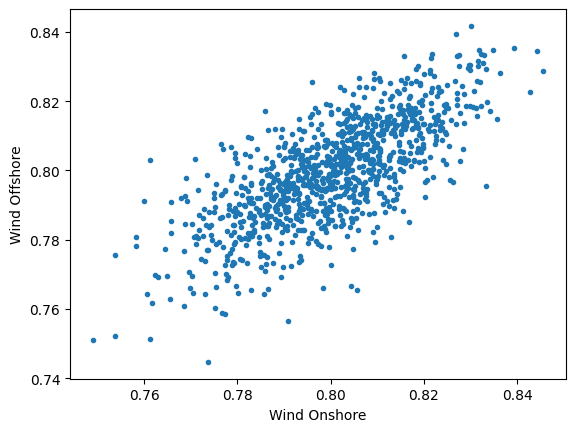

In [36]:
paths_1 = results['Onshore'].get_fwd(-1,-1)
paths_2 = results['Offshore'].get_fwd(-1,-1)
plt.plot(paths_1,paths_2,'.')
plt.xlabel('Wind Onshore')
plt.ylabel('Wind Offshore');

In [53]:
rdm = ResidualDemandForwardModel(multi_region_model, 
                                 highest_price,
                                SmoothstepSupplyCurve(1.0, 0),
                                 max_price = 1.0,
                                 #forecast_hours=[#6, 
                                 #                10, 14, 18], 
                                )
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1]]
n_sims = 1_000
rnd = np.random.normal(size=rdm.rnd_shape(n_sims, timegrid.shape[0]))
power_fwd, efficiencies = rdm.simulate(timegrid, rnd, forecast_points)

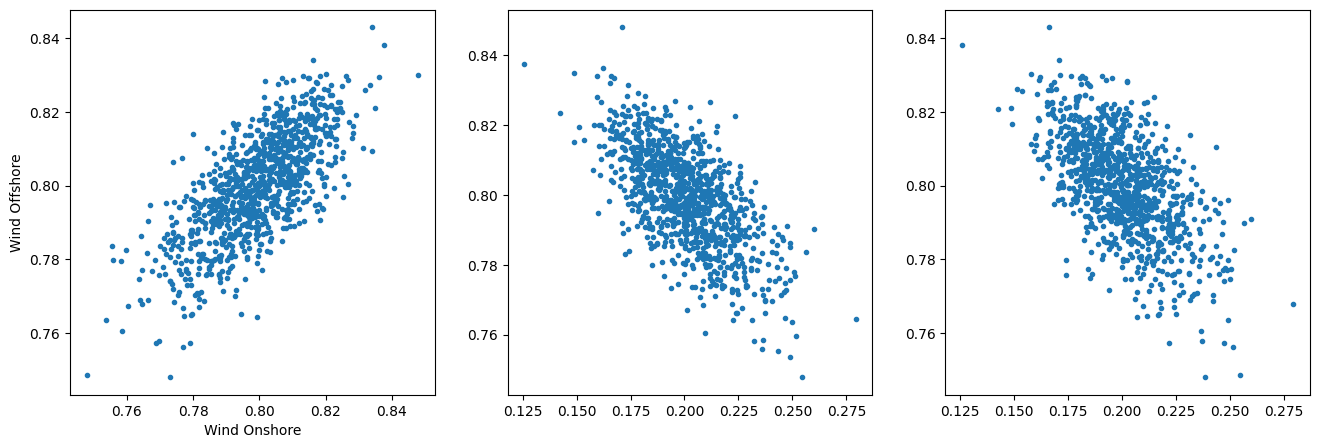

In [54]:
plt.figure(figsize=(16,5))
paths_1 = efficiencies['Onshore'][-1,:,-1]
paths_2 = efficiencies['Offshore'][-1,:,-1]
plt.subplot(1,3,1)
plt.plot(paths_1,paths_2,'.')
plt.xlabel('Wind Onshore')
plt.ylabel('Wind Offshore');
plt.subplot(1,3,2)
plt.plot(power_fwd[-1,:,-1],paths_1,'.')
plt.subplot(1,3,3)
plt.plot(power_fwd[-1,:,-1],paths_2,'.');

# Hedging

In [5]:
val_date = dt.datetime(2023,1,1)
strike = 0.22#fwd_prices[:,-1].mean()
spec = GreenPPASpecification(technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [6]:

days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24+1)
#forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1]]
n_sims = 10_000

regions = [ MultiRegionWindForecastModel.Region( 
                                    WindPowerForecastModel(speed_of_mean_reversion=0.1, 
                                                           volatility=4.80, 
                                                            expiries=forward_expiries,
                                                            forecasts = [0.8],#*len(forward_expiries)
                                                            region = 'Onshore'
                                                            ),
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    WindPowerForecastModel(speed_of_mean_reversion=0.5, 
                                                           volatility=4.80, 
                                                            expiries=forward_expiries,
                                                            forecasts = [0.6],#*len(forward_expiries)
                                                            region = 'Offshore'
                                                            ),
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
multi_region_wind_foecast_model = MultiRegionWindForecastModel(regions)
wind_forecast_model = multi_region_wind_foecast_model._region_forecast_models[0]

highest_price = OrnsteinUhlenbeck(speed_of_mean_reversion=1.0, volatility=0.01, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rdm = ResidualDemandForwardModel(
                                #wind_forecast_model, 
                                 multi_region_wind_foecast_model,
                                 highest_price,
                                 supply_curve,
                                 max_price = 1.0,
                                 forecast_hours=[6, 
                                                 10, 14, 18], 
                                #region_to_capacity=None
                                )

In [39]:
tensorboard_logdir = os.path.join("logs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
regularization = 0.05
result = price(val_date, spec, rdm , 
               depth=3, nb_neurons=64, 
               n_sims = n_sims, 
               regularization= regularization, 
              epochs = 200, 
              verbose=1, 
              initial_lr = 1e-2,
              batch_size=400,
              decay_rate=0.6,
              tensorboard_logdir=tensorboard_logdir
            )
try:
    results[str(regularization)] = result
except:
    results = {}
    results[str(regularization)] = result

Epoch 1/200
25/25 [==============================] - 12s 53ms/step - loss: 0.0032
Epoch 2/200
25/25 [==============================] - 1s 52ms/step - loss: 2.3481e-04
Epoch 3/200
25/25 [==============================] - 1s 48ms/step - loss: 1.8891e-04
Epoch 4/200
25/25 [==============================] - 1s 49ms/step - loss: 1.7960e-04
Epoch 5/200
25/25 [==============================] - 1s 48ms/step - loss: 1.8166e-04
Epoch 6/200
25/25 [==============================] - 1s 50ms/step - loss: 1.7881e-04
Epoch 7/200
25/25 [==============================] - 1s 48ms/step - loss: 1.7827e-04
Epoch 8/200
25/25 [==============================] - 1s 49ms/step - loss: 1.7859e-04
Epoch 9/200
25/25 [==============================] - 1s 48ms/step - loss: 1.7977e-04
Epoch 10/200
25/25 [==============================] - 1s 48ms/step - loss: 1.8252e-04
Epoch 11/200
25/25 [==============================] - 1s 49ms/step - loss: 1.8027e-04
Epoch 12/200
25/25 [==============================] - 1s 50ms/step

25/25 [==============================] - 1s 47ms/step - loss: 1.7886e-04
Epoch 97/200
25/25 [==============================] - 1s 47ms/step - loss: 1.7722e-04
Epoch 98/200
25/25 [==============================] - 1s 44ms/step - loss: 1.7674e-04
Epoch 99/200
25/25 [==============================] - 1s 44ms/step - loss: 1.7718e-04
Epoch 100/200
25/25 [==============================] - 1s 48ms/step - loss: 1.7822e-04
Epoch 101/200
25/25 [==============================] - 1s 47ms/step - loss: 1.7719e-04
Epoch 102/200
25/25 [==============================] - 1s 43ms/step - loss: 1.7800e-04
Epoch 103/200
25/25 [==============================] - 1s 44ms/step - loss: 1.7793e-04
Epoch 104/200
25/25 [==============================] - 1s 46ms/step - loss: 1.7877e-04
Epoch 105/200
25/25 [==============================] - 1s 48ms/step - loss: 1.7856e-04
Epoch 106/200
25/25 [==============================] - 1s 47ms/step - loss: 1.7817e-04
Epoch 107/200
25/25 [==============================] - 1s 43

25/25 [==============================] - 1s 44ms/step - loss: 1.7677e-04
Epoch 191/200
25/25 [==============================] - 1s 41ms/step - loss: 1.7740e-04
Epoch 192/200
25/25 [==============================] - 1s 42ms/step - loss: 1.7714e-04
Epoch 193/200
25/25 [==============================] - 1s 47ms/step - loss: 1.7926e-04
Epoch 194/200
25/25 [==============================] - 1s 49ms/step - loss: 1.7682e-04
Epoch 195/200
25/25 [==============================] - 1s 43ms/step - loss: 1.7710e-04
Epoch 196/200
25/25 [==============================] - 1s 41ms/step - loss: 1.7715e-04
Epoch 197/200
25/25 [==============================] - 1s 41ms/step - loss: 1.7668e-04
Epoch 198/200
25/25 [==============================] - 1s 47ms/step - loss: 1.7715e-04
Epoch 199/200
25/25 [==============================] - 1s 43ms/step - loss: 1.7680e-04
Epoch 200/200
25/25 [==============================] - 1s 41ms/step - loss: 1.7869e-04


C:\Users\doeltz\AppData\Local\Temp\ipykernel_6792\67340456.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i)


313/313 [==============================] - 1s 2ms/step


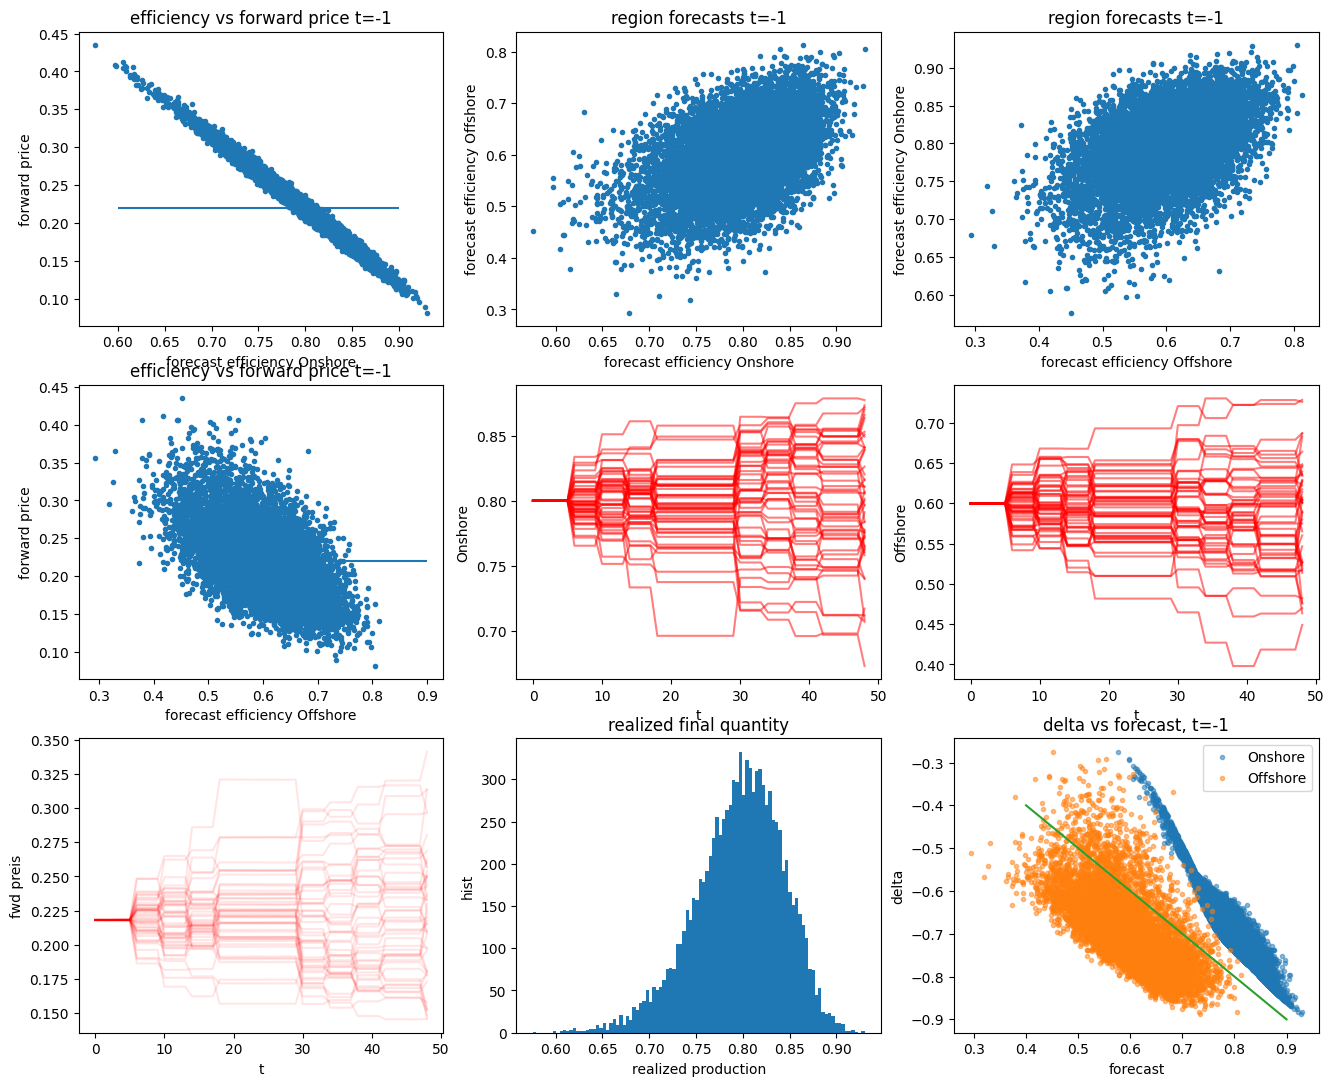

In [52]:
t=-1
plt.figure(figsize=(16,13))
i=1
plt.title(str(result.timegrid.dates[t]))
for k,v in result.forecasts.items():
    for l,w in result.forecasts.items():
        plt.subplot(3,3,i) 
        if k==l:
            plt.title('efficiency vs forward price t='+str(t))
            plt.plot(w[:,t], result.fwd_prices[:,t], '.')
            plt.hlines(strike,0.6,0.9)
            plt.xlabel('forecast efficiency ' + k)
            plt.ylabel('forward price')
        else:
            plt.title('region forecasts t='+str(t))
            plt.plot(v[:,t], w[:,t], '.')
            plt.xlabel('forecast efficiency ' + k)
            plt.ylabel('forecast efficiency ' + l)
        i += 1

for k,v in result.forecasts.items():
    #label = k
    plt.subplot(3,3,i)
    for l in range(50):
        plt.plot(v[l,:], '-r', alpha=0.5)
    plt.ylabel(k)
    plt.xlabel('t')
    i += 1
plt.subplot(3,3,i)
for l in range(50):
    plt.plot(result.fwd_prices[l,:], '-r', alpha=0.1)
plt.ylabel('fwd preis')
plt.xlabel('t')
i += 1
plt.subplot(3,3,i)
plt.hist(result.rlzd_qty.reshape((-1)), bins=100)
plt.title('realized production')
plt.xlabel('realized production')
plt.ylabel('hist')
plt.title('realized final quantity')
i += 1
plt.subplot(3,3,i)
#delta = result.hedge_model.model.predict([fwd_prices[:,t], forecasts[:,t], np.array([timegrid[t]]*forecasts.shape[0])]).reshape((-1))
delta = result.hedge_model.compute_delta(result.fwd_prices, result.forecasts, t)
for k,v in result.forecasts.items():
    plt.plot( v[:,t], delta,'.', label=k, alpha=0.5)
plt.ylabel('delta')
plt.xlabel('forecast')
plt.plot([0.4, 0.9],[-0.4, -0.9])
plt.legend()
plt.title('delta vs forecast, t='+str(t))
i += 1

313/313 [==============================] - 1s 2ms/step


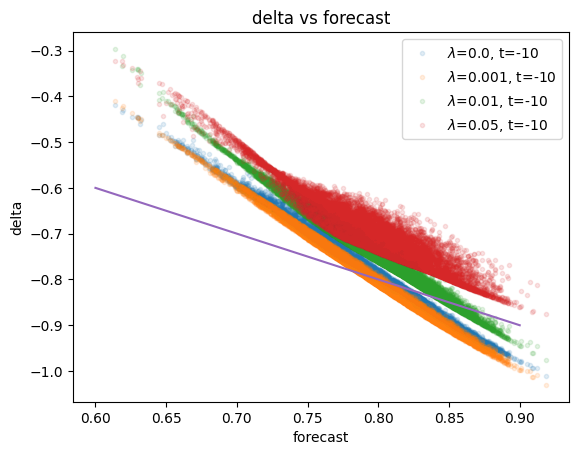

In [51]:
for k,v in results.items():
    for t_ in range(-10,-8,2):
        delta = v.hedge_model.compute_delta(v.fwd_prices, v.forecasts, t_)
        for l,v in v.forecasts.items():
            if l != 'Onshore':
                continue
            plt.plot( v[:,t_], delta,'.', alpha=0.125, label='$\lambda$='+k+', t=' + str(t_))
plt.ylabel('delta')
plt.xlabel('forecast')
plt.plot([0.6, 0.9],[-0.6, -0.9])
plt.legend()
plt.title('delta vs forecast');


In [47]:
results.keys()

dict_keys(['0.0', '0.001', '0.01', '0.05'])

In [42]:
if False:
    plt.figure(figsize=(12,9))
    #forecast_points = [i for i in range(len(timegrid)) if i%8==0]
    fwd_prices = result.fwd_prices
    forecasts_ = result.forecasts[spec.location]
    rlzd_qty = result.rlzd_qty


    print('strike', strike)
    plt.subplot(2,2,1)
    #print('hedge_delta', (-fwd_residuals[-1]+1.0))
    pnl_no_hedge = (fwd_prices[:,-1]-strike)*forecasts_[:,-1]
    #bins = plt.hist(pnl_no_hedge, bins=50, label='no hedge', density=True)
    delta = -1.0*forecasts_[:,0]
    pnl_hedge = pnl_no_hedge + (fwd_prices[:,-1]-fwd_prices[:,0])*delta
    plt.hist(pnl_hedge,  label='delta=-forecast', alpha=1.0, density=True, bins=50)
    print(pnl_hedge.mean())
    delta = -1.0*forecasts_[:,0]
    #pnl_hedge = pnl_no_hedge + (fwd_prices[:,-1]-fwd_prices[:,0])*delta
    #plt.hist(pnl_hedge,  label='delta=-forecast', alpha=0.5, density=True, bins=50)
    #print(pnl_hedge.mean())

    pnl_hedge_dynamic_volume = -fwd_prices[:,0]*forecasts_[:,0]
    for i in range(1,fwd_prices.shape[1]):
        pnl_hedge_dynamic_volume += (forecasts_[:,i-1]-forecasts_[:,i])*fwd_prices[:,i]
    pnl_hedge_dynamic_volume += forecasts_[:,-2]*fwd_prices[:,-1] + forecasts_[:,-1]*(fwd_prices[:,-1]-strike)
    #plt.hist(pnl_hedge_dynamic_volume,  label='dynamic delta=-forecast', alpha=0.5, density=True, bins=50)

    #delta = -0pnl_hedge_dynamic_volume8*(-fwd_residuals[0,:]+1.0)
    #pnl_hedge = pnl_no_hedge + (fwd_prices[-1,:]-fwd_prices[0,:])*delta
    #plt.hist(pnl_hedge,  label='delta=-0.8*forecast', alpha=0.5, density=True, bins=50)
    plt.xlabel('pnl')
    plt.legend()
    plt.title('pnl static volume hedge')
    plt.subplot(2,2,2)
    plt.hist(forecasts_[:,-1], bins=50);
    plt.title('realized wind')
    plt.xlabel('efficiency ' + spec.location)
    plt.subplot(2,2,3)
    plt.hist(fwd_prices[:,-1], bins=50)
    plt.title('p(T)')
    plt.xlabel('spot price')
    plt.subplot(2,2,4)
    plt.plot( forecasts_[:,-1], fwd_prices[:,-1],'.');
    plt.ylabel('fwd price')
    plt.xlabel('efficiency ' + spec.location);

313/313 [==============================] - 1s 3ms/step
0.0034518330981755164 0.001165531
-0.0036338917599490037 -0.0035949463
313/313 [==============================] - 1s 3ms/step
0.0034518330981755164 0.0011836203
-0.0036338917599490037 -0.0035831062
313/313 [==============================] - 1s 3ms/step
0.0034518330981755164 0.0019062449
-0.0036338917599490037 -0.0034623935
313/313 [==============================] - 1s 4ms/step
0.0034518330981755164 0.0038293728
-0.0036338917599490037 -0.003272846


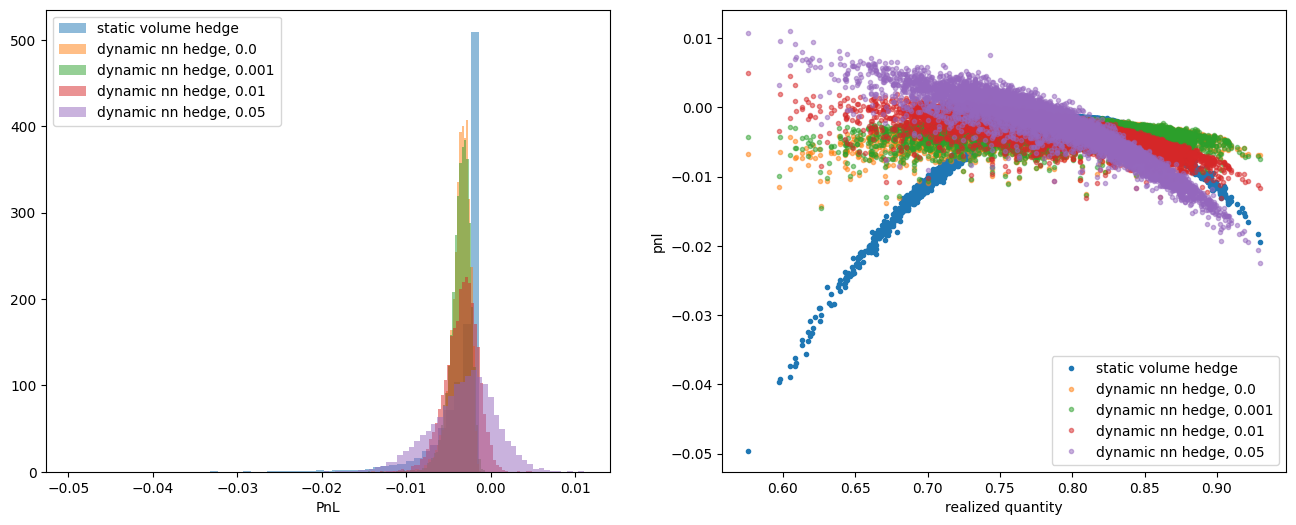

In [55]:
#plt.hist(pnl_no_hedge, bins=50, density=True, label='unhedged')
plt.figure(figsize=(16,6))
plt.subplot(1,2,2)
plt.plot(rlzd_qty, pnl_hedge, '.', label='static volume hedge')
plt.subplot(1,2,1)
plt.hist(pnl_hedge, bins=50, density=True, alpha=0.5, label='static volume hedge')
for k,v in results.items():
    plt.subplot(1,2,1)
    pnl = v.hedge_model.compute_pnl(result.fwd_prices, result.forecasts, result.rlzd_qty)
    plt.hist(pnl, bins=50, density=True, alpha=0.5, label='dynamic nn hedge, ' + str(k))
    print(np.sqrt(pnl_hedge.var()), np.sqrt(pnl.var()))
    print(pnl_hedge.mean(), pnl.mean())
    plt.subplot(1,2,2)
    plt.plot(rlzd_qty, pnl, '.', alpha=0.5, label='dynamic nn hedge, ' + str(k))

plt.subplot(1,2,1)
plt.xlabel('PnL')
plt.legend();

plt.subplot(1,2,2)
plt.xlabel('realized quantity')
plt.ylabel('pnl')
plt.legend();
#plt.savefig('deep_hedging.png', dpi=600)